9301/9301 [==============================] - 175s 19ms/step - loss: 0.1709 - accuracy: 0.9548


INFO:tensorflow:Assets written to: trainedHandwrittenConv\assets


INFO:tensorflow:Assets written to: trainedHandwrittenConv\assets


2326/2326 [==============================] - 14s 6ms/step - loss: 0.0912 - accuracy: 0.9753
The testing accuracy is : 0.9752580523490906
The testing loss is : 0.09118039906024933


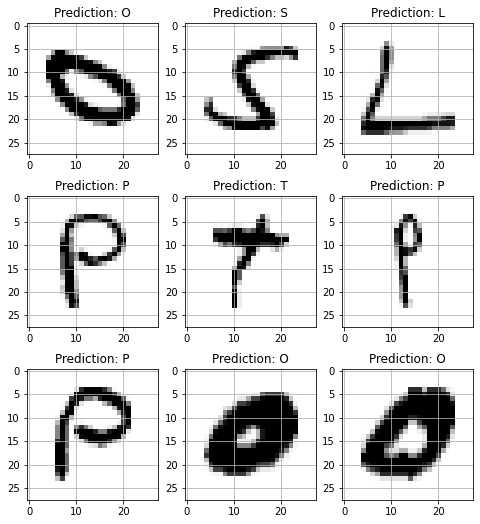

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#change this boolean to use model with convolution layers
useConvolutionLayers=True

#loading the dataset into memory
dataset=pd.read_csv(r"A_Z HandwrittenData.csv").astype('float32')

#splitting the columns into images and labels
images= dataset.drop('0',axis=1)#
labels=dataset['0']

#spliting the data int train and test parts
train_images, test_images, train_labels, test_labels=train_test_split(images, labels, test_size=0.2)

#reshaping the images to be interpeted as 28x28 2D arrays
train_images = np.reshape(train_images.values, (train_images.shape[0], 28,28))
test_images = np.reshape(test_images.values, (test_images.shape[0], 28,28))

#creating a dictionary with the assigned values to the letters
letter_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}

#assiging values to the labels of the images
train_labels2 = to_categorical(train_labels, num_classes = 26, dtype='int')
test_labels2 = to_categorical(test_labels, num_classes = 26, dtype='int')

#creating the model, adding layers
model = tf.keras.models.Sequential()

if(useConvolutionLayers==True):
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))#shape:26x26x32
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))#shape:13x13x32
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))#shape:13x13x64
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))#shape:6x6x64
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))#shape:4x4x128
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))#shape:2x2x128
    model.add(tf.keras.layers.Flatten())#shape: 512
    model.add(tf.keras.layers.Dense(64,activation ="relu"))
    model.add(tf.keras.layers.Dense(128,activation ="relu"))
    model.add(tf.keras.layers.Dense(26,activation ="softmax"))
else:
    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))#shape: 28x28x1
    model.add(tf.keras.layers.Dense(256,activation ="relu"))#shape: 256
    model.add(tf.keras.layers.Dense(256,activation ="relu"))#shape: 256
    model.add(tf.keras.layers.Dense(26,activation ="softmax"))#shape: 26

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels2, epochs=1)
if(useConvolutionLayers==True):
    model.save('trainedHandwrittenConv')
else:
    model.save('trainedHandwrittenBasic')
#model= tf.keras.models.load_model('trainedHandwritten')
loss, accuracy =model.evaluate(test_images, test_labels2)
print("The testing accuracy is :", accuracy)
print("The testing loss is :", loss)
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()
for i,ax in enumerate(axes):
    img = np.reshape(test_images[i], (28,28))
    ax.imshow(img, cmap="Greys")
    
    pred = letter_dict[np.argmax(test_labels2[i])]
    ax.set_title("Prediction: "+pred)
    ax.grid()

1/1 [==============================] - 0s 38ms/step
0
1
1/1 [==============================] - 0s 12ms/step
0
1
Conv Model
1/1 [==============================] - 0s 57ms/step
0
1


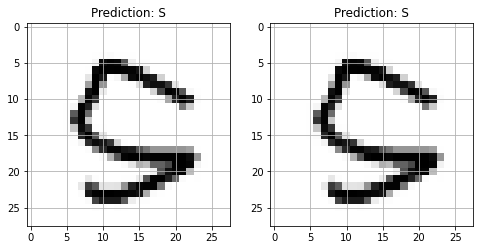

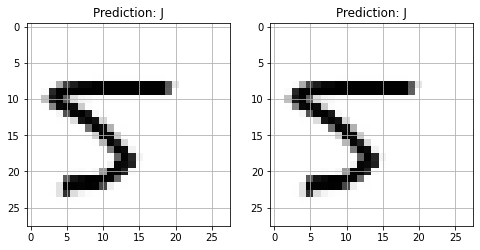

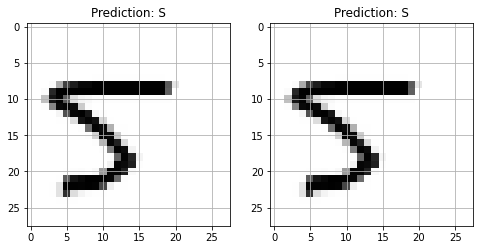

In [34]:
from tkinter import *
from tkinter import ttk, colorchooser, filedialog
from PIL import ImageTk, Image, ImageDraw
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
model= tf.keras.models.load_model('trainedHandwrittenBasic')
model2= tf.keras.models.load_model('trainedHandwrittenConv')
letter_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}
letter='none'
currentModel=model
class main:
    def __init__(self,master):
        self.master = master
        self.color_fg = 'white'
        self.color_bg = 'black'
        self.old_x = None
        self.old_y = None
        self.penwidth = 10
        self.drawWidgets()
        self.c.bind('<B1-Motion>',self.paint)#drwaing the line 
        self.c.bind('<ButtonRelease-1>',self.reset)
        self.image=Image.new("RGB",(200,200),(0,0,0))
        self.draw=ImageDraw.Draw(self.image)

    def paint(self,e):
        if self.old_x and self.old_y:
            self.c.create_line(self.old_x,self.old_y,e.x,e.y,width=self.penwidth,fill=self.color_fg,capstyle=ROUND,smooth=True)
            self.draw.line(((self.old_x,self.old_y),(e.x,e.y)),fill=self.color_fg, width=15)

        self.old_x = e.x
        self.old_y = e.y

    def reset(self,e):    #reseting or cleaning the canvas 
        self.old_x = None
        self.old_y = None      
        
    def clear(self):
        self.c.delete(ALL)
        self.draw.rectangle((0,0,200,200), fill=(0,0,0,0))
    def swapmodels(self):
        global currentModel
        if(currentModel==model2):
            print("Basic model")
            currentModel=model
        else:
            print("Conv Model")
            currentModel=model2
            
    def recognize(self):
    
        filename = "temp.jpg"
        self.image.save(filename)

        
        
        img = cv2.imread(filename)
        img_copy = img.copy()


        img_copy = cv2.GaussianBlur(img_copy, (7,7), 0)
        img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

        img_final = cv2.resize(img_gray, (28,28))

        img_final =np.reshape(img_final, (1,28,28))
        
        global currentModel
        letter= letter_dict[np.argmax(currentModel.predict(img_final))]
        self.text.delete("1.0", "end")  # if you want to remove the old data
        self.text.insert(END,letter)
        
        
        fig, axes = plt.subplots(1,2, figsize=(8,9))
        axes = axes.flatten()
        for i,ax in enumerate(axes):
            img = np.reshape(img_final[0], (28,28))
            ax.imshow(img, cmap="Greys")
            print(i)
            ax.set_title("Prediction: "+str(letter))
            ax.grid()
            
    
        
    def drawWidgets(self):   

        self.c = Canvas(self.master,width=200,height=200,bg=self.color_bg)
        self.c.grid(row=0, column=0, sticky=W)
        #self.c.pack()
        #self.board1 = Frame(self.master, bg="blue") .grid(row=0, column=0, sticky=W,padx=200,pady=200)
        

        #self.board2 = Frame(self.master, bg="black")
        #self.board2.place(relwidth=1, relheight=0.5, relx=0.5, rely=0.5)
        self.text = Text(root)
        self.text.grid(row=2, column=1, sticky=W)
        self.text.insert(INSERT,letter)
        recognizeButton=Button(self.master, text="Recognize", padx=10, pady=5, 
                        fg="black", bg="green", command=self.recognize) .grid(row=1, column=0, sticky=W)
        resetButton=Button(self.master, text="Reset", padx=10, pady=5, 
                        fg="black", bg="green", command=self.clear) .grid(row=1, column=1, sticky=W)
        swapButton=Button(self.master, text="Swap Model", padx=10, pady=5, 
                        fg="black", bg="green", command=self.swapmodels) .grid(row=0, column=1, sticky=W)

if __name__ == '__main__':
    root = Tk()
    root.wm_geometry("%dx%d+%d+%d" % (400, 400, 10, 10))
    root.config(bg='white')
    main(root)
    root.title('char guesser')

    root.mainloop()